# OBIS Dataset - Using environmental and temporal features to classify species into IUCN Redlist Categories

## To get the OBIS data set - Download parquet file using link: https://obis.org/data/access/

### Setup

In [1]:
# Importing important libraries
import os, pickle, glob
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
from pyspark.sql import functions as f
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.mllib.evaluation import MulticlassMetrics

import seaborn as sns
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 

Matplotlib created a temporary cache directory at /scratch/erichards/job_30677137/matplotlib-h9bndxqt because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Builds the Spark Session
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
	.config("spark.executor.memory", "8g") \
    .config('spark.executor.instances', 15) \
	.getOrCreate()

In [3]:
# Sets up the sql context
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Loading the data

#### Change the path to where you saved your OBIS parquet file

In [4]:
# Loading parquet file 
df = sqlContext.read.load('../obis_20231025.parquet')

In [5]:
# Loading csv file
df_iucn = sqlContext.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('assessments.csv')

In [6]:
# Show the schema for OBIS
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- dataset_id: string (nullable = true)
 |-- decimalLongitude: float (nullable = true)
 |-- decimalLatitude: float (nullable = true)
 |-- date_start: long (nullable = true)
 |-- date_mid: long (nullable = true)
 |-- date_end: long (nullable = true)
 |-- date_year: long (nullable = true)
 |-- scientificName: string (nullable = true)
 |-- originalScientificName: string (nullable = true)
 |-- minimumDepthInMeters: float (nullable = true)
 |-- maximumDepthInMeters: float (nullable = true)
 |-- depth: float (nullable = true)
 |-- coordinateUncertaintyInMeters: float (nullable = true)
 |-- flags: string (nullable = true)
 |-- dropped: boolean (nullable = true)
 |-- absence: boolean (nullable = true)
 |-- shoredistance: string (nullable = true)
 |-- bathymetry: string (nullable = true)
 |-- sst: string (nullable = true)
 |-- sss: string (nullable = true)
 |-- marine: boolean (nullable = true)
 |-- brackish: boolean (nullable = true)
 |-- freshwater: bo

In [7]:
# Show the schema for the IUCN dataset
df_iucn.printSchema()

root
 |-- scientificName: string (nullable = true)
 |-- redlistCategory: string (nullable = true)
 |-- assessmentDate: string (nullable = true)



### Data Exploration

#### Distinct Observations per year

In [8]:
# Aggregates counts for distinct dates
df_dates = df.groupBy(df.date_year).agg({'date_year':'count'}).sort(df.date_year).cache()

In [9]:
# Renames column
df_dates = df_dates.withColumnRenamed('count(date_year)','obs_per_year')

In [10]:
# Shows date counts
df_dates.show()

+---------+------------+
|date_year|obs_per_year|
+---------+------------+
|     NULL|           0|
|      201|           1|
|      931|           1|
|      941|           1|
|      966|           1|
|     1064|           2|
|     1071|           2|
|     1073|           2|
|     1076|           1|
|     1103|           1|
|     1104|           1|
|     1116|           2|
|     1119|           2|
|     1193|           1|
|     1199|           4|
|     1200|           1|
|     1291|           1|
|     1520|           1|
|     1526|           1|
|     1596|           1|
+---------+------------+
only showing top 20 rows



In [11]:
# Converts pyspark df to pandas df
pandas_df_dates = df_dates.toPandas()

In [12]:
# Filtering out dates below 1899 
pandas_df_dates_cut = pandas_df_dates[pandas_df_dates.date_year > 1899]

Text(0, 0.5, 'Observations(per 10 million)')

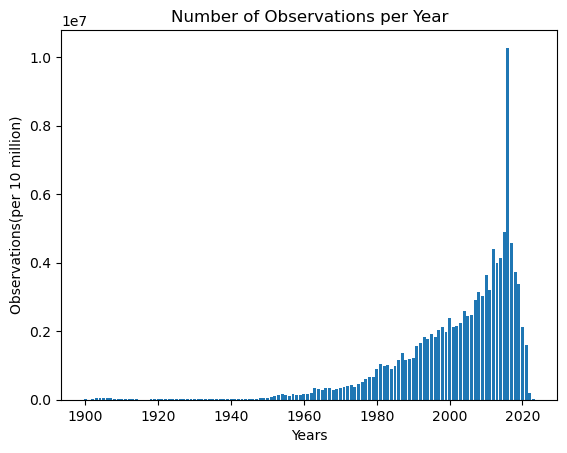

In [13]:
# Plots out counts per year
plt.bar(pandas_df_dates_cut.date_year,pandas_df_dates_cut.obs_per_year)
plt.title("Number of Observations per Year")
plt.xlabel("Years")
plt.ylabel("Observations(per 10 million)")

#### Distinct IUCN classification by Species 

In [14]:
# Distinct counts of species 
df.select("scientificName","redlist_category").filter(df.scientificName != "").filter(df.redlist_category != "").distinct().count()

1979

In [15]:
# Grabs the distinct scientificNames and their redlist categories
df_redlist_distinct = df.select("scientificName","redlist_category").filter(df.scientificName != "").filter(df.redlist_category != "").distinct().cache()

In [16]:
# IUCN classification by species 
df_redlist_distinct.show()

+--------------------+----------------+
|      scientificName|redlist_category|
+--------------------+----------------+
|  Glaucostegus typus|              CR|
|Echinopelta fistu...|              NT|
|   Hippocampus comes|              VU|
|Diplobatis colomb...|              VU|
|Eretmochelys imbr...|              CR|
|Pterodroma arminj...|              VU|
|  Porites nigrescens|              VU|
|  Squalus montalbani|              VU|
|   Ecsenius randalli|              VU|
|   Leptastrea bottae|              NT|
|    Dialommus fuscus|              VU|
|       Oxyura maccoa|              EN|
|Glaucostegus gran...|              CR|
|  Centrophorus uyato|              EN|
|Argyrosomus inodorus|              VU|
|Caulastraea echin...|              VU|
|   Alveopora viridis|              NT|
|    Calidris pusilla|              NT|
|   Hippocampus reidi|              NT|
|    Leptoria phrygia|              NT|
+--------------------+----------------+
only showing top 20 rows



In [17]:
# Aggregates based on redlist groups
df_redlist_count = df_redlist_distinct.select("redlist_category").groupBy("redlist_category").agg({'redlist_category':'count'})

In [18]:
# Renames columns
df_redlist_count = df_redlist_count.withColumnRenamed('count(redlist_category)','obs_per_cat')

In [19]:
# Count of unique redlist categorized species
df_redlist_count.show()

+----------------+-----------+
|redlist_category|obs_per_cat|
+----------------+-----------+
|              EX|          8|
|              NT|        562|
|           LR/nt|          5|
|              EN|        371|
|              CR|        225|
|           LR/cd|          5|
|              EW|          1|
|              VU|        802|
+----------------+-----------+



In [20]:
# Converts pyspark df to pandas df
pandas_redlist_count = df_redlist_count.toPandas()

Text(0, 0.5, 'Number of species')

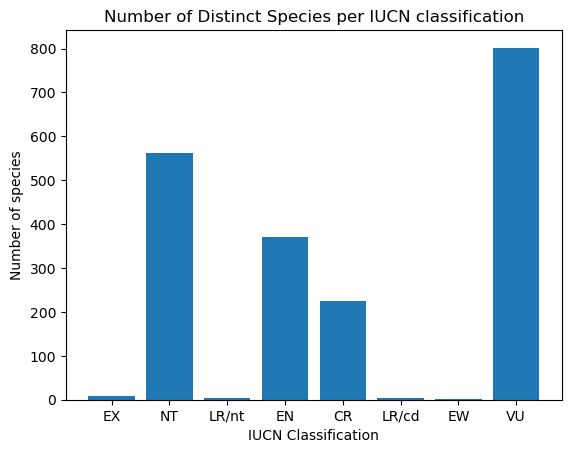

In [21]:
# Plots out uniqe redlist category counts per year
plt.bar(pandas_redlist_count.redlist_category,pandas_redlist_count.obs_per_cat)
plt.title("Number of Distinct Species per IUCN classification")
plt.xlabel("IUCN Classification")
plt.ylabel("Number of species")

#### Orca observations over time

In [22]:
# Creates df that checks orca sightings per year via aggregation
df_orca = df.filter(df.scientificName == "Orcinus orca").select("date_year").groupBy("date_year").agg({'date_year':'count'}).sort("date_year").cache()

In [23]:
# Renames column
df_orca = df_orca.withColumnRenamed('count(date_year)','obs_per_year')

In [24]:
# Shows orca sightings per year
df_orca.show()

+---------+------------+
|date_year|obs_per_year|
+---------+------------+
|     NULL|           0|
|     1758|           4|
|     1822|           2|
|     1824|           1|
|     1844|           1|
|     1848|           1|
|     1866|           2|
|     1871|           1|
|     1872|           1|
|     1884|           1|
|     1894|           1|
|     1910|           2|
|     1911|           8|
|     1912|           6|
|     1913|           2|
|     1916|           1|
|     1918|           3|
|     1920|           1|
|     1921|           1|
|     1924|           2|
+---------+------------+
only showing top 20 rows



In [25]:
# Converts pyspark df to pandas df
pandas_orca = df_orca.toPandas()

Text(0, 0.5, 'Number of observations')

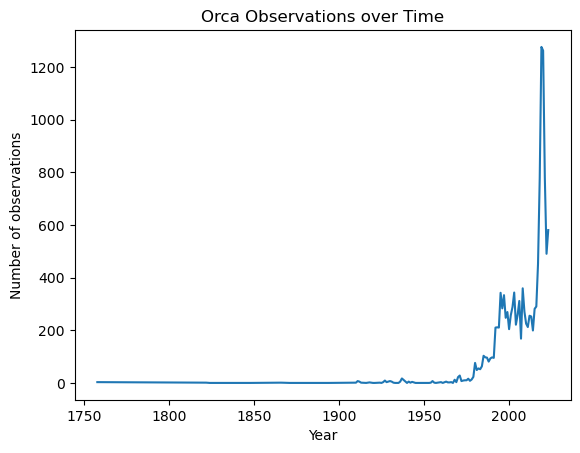

In [26]:
# Plots out orca sightings per year
plt.plot(pandas_orca.date_year,pandas_orca.obs_per_year)
plt.title("Orca Observations over Time")
plt.xlabel("Year")
plt.ylabel("Number of observations")

#### Null Counts

In [27]:
# Null Counts
null_counts = df.select([f.sum(f.col(column).isNull().cast("int")).alias(column) for column in df.columns])
null_counts_dict = null_counts.collect()[0].asDict()
null_counts_df = sc.createDataFrame(null_counts_dict.items(), ["column_name", "null_count"])
num_rows = null_counts_df.count()
null_counts_df.show(num_rows, truncate=False)

+-----------------------------------+----------+
|column_name                        |null_count|
+-----------------------------------+----------+
|id                                 |0         |
|dataset_id                         |0         |
|decimalLongitude                   |0         |
|decimalLatitude                    |0         |
|date_start                         |5113635   |
|date_mid                           |5113635   |
|date_end                           |5113635   |
|date_year                          |5113635   |
|scientificName                     |14785     |
|originalScientificName             |43072     |
|minimumDepthInMeters               |55961796  |
|maximumDepthInMeters               |52565014  |
|depth                              |50283294  |
|coordinateUncertaintyInMeters      |63710247  |
|flags                              |178       |
|dropped                            |0         |
|absence                            |0         |
|shoredistance      

### Data Preparation

#### OBIS Aggregation

In [28]:
# Selecting important columns
df_trim_col = df.select(
    'id',
    'decimalLongitude',
    'decimalLatitude',
    'date_year',
    'scientificName',
    'coordinateUncertaintyInMeters',
    'shoredistance',
    'bathymetry',
    'sst',
    'sss',
    'marine',
    'brackish',
    'freshwater',
    'terrestrial',
    'taxonRank',
    'redlist_category',
    'superdomain',
    'domain',
    'kingdom',
    'subkingdom',
    'infrakingdom',
    'phylum',
    'phylum_division',
    'subphylum_subdivision',
    'subphylum',
    'infraphylum',
    'parvphylum',
    'gigaclass',
    'megaclass',
    'superclass',
    'class',
    'subclass',
    'infraclass',
    'subterclass',
    'superorder',
    'order',
    'suborder',
    'infraorder',
    'parvorder',
    'superfamily',
    'family',
    'subfamily',
    'supertribe',
    'tribe',
    'subtribe',
    'genus',
    'subgenus',
    'section',
    'subsection',
    'series',
    'species',
    'subspecies',
    'natio',
    'variety',
    'subvariety',
    'forma',
    'subforma',
    'individualCount',
    'eventDate'
)

In [29]:
# Creating a date parser
from dateutil import parser

def extract_year(date_str):
    try:
        parsed_date = parser.parse(date_str, fuzzy=True)
        return parsed_date.year
    except:
        return None

extract_year_udf = f.udf(extract_year, IntegerType())

In [30]:
# Adds missing years to date_year, drops eventDate, and filters out null date_years
df_year_fix = df_trim_col.withColumn(
    "date_year",
    f.when(f.col("date_year").isNull(), extract_year_udf(f.col("eventDate")))
    .otherwise(f.col("date_year"))
).drop("eventDate").filter(f.col("date_year").isNotNull())

In [31]:
# Filters out scientific names that are null and handles an old name
df_sci_name_fix = df_year_fix.filter(f.col("scientificName").isNotNull()).withColumn("scientificName", f.regexp_replace('scientificName', 'Taenioides jacksoni', 'Trypauchenopsis intermedia'))

In [32]:
# Filters out overly uncertain coordinates
df_uncert_fix = df_sci_name_fix.filter((f.col("coordinateUncertaintyInMeters") <= 1000) | (f.col("coordinateUncertaintyInMeters").isNull()))
df_uncert_fix = df_uncert_fix.withColumn(
    "coordinateUncertaintyInMeters",
    f.when(f.col("coordinateUncertaintyInMeters").isNull(), f.col("coordinateUncertaintyInMeters") == 0)).drop("coordinateUncertaintyInMeters")

In [33]:
# Filters out null environmental data
df_env_fix = df_uncert_fix.filter(f.col("sst").isNotNull()).filter(f.col("sss").isNotNull()).filter(f.col("bathymetry").isNotNull())

In [34]:
# Transforms counts into integers
df_indiv_cnt_fix = df_env_fix.withColumn('individualCount', 
                                         f.when(f.col('individualCount').isNotNull(), 
                                         f.col('individualCount').cast('int'))
                                         .otherwise(None)
                                        )

In [35]:
# Counts obtained from other columns
df_count_fix = df_indiv_cnt_fix.withColumn(
    'count',
    f.when((f.col('individualCount').isNull()) | (f.col('individualCount') <= 1), 1)
    .when((f.col('individualCount') > 1), f.col('individualCount'))
    .otherwise(None)
).drop('individualCount')

In [36]:
# Generates a aggregated table based on scientificName and date_year
aggregated_df = df_count_fix.groupBy("scientificName", "date_year").agg(
    f.min("decimalLongitude").alias("min_decimalLongitude"),
    f.max("decimalLongitude").alias("max_decimalLongitude"),
    f.min("decimalLatitude").alias("min_decimalLatitude"),
    f.max("decimalLatitude").alias("max_decimalLatitude"),
    f.avg("shoredistance").alias("avg_shoredistance"),
    f.avg("bathymetry").alias("avg_bathymetry"),
    f.avg("sst").alias("avg_sst"),
    f.avg("sss").alias("avg_sss"),
    f.sum("count").alias("sum_count")
)

In [37]:
# Log trandsforms the counts to normalize them
aggregated_df_log_trans= aggregated_df.withColumn("log_sum_count", f.log1p("sum_count"))

In [38]:
# Creating a table to add back in the lost cladogram data
df_clado_unique = df_year_fix.select(
    'date_year',
    'scientificName',
    'marine',
    'brackish',
    'freshwater',
    'terrestrial',
    'superdomain',
    'domain',
    'kingdom',
    'subkingdom',
    'infrakingdom',
    'phylum',
    'phylum_division',
    'subphylum_subdivision',
    'subphylum',
    'infraphylum',
    'parvphylum',
    'gigaclass',
    'megaclass',
    'superclass',
    'class',
    'subclass',
    'infraclass',
    'subterclass',
    'superorder',
    'order',
    'suborder',
    'infraorder',
    'parvorder',
    'superfamily',
    'family',
    'subfamily',
    'supertribe',
    'tribe',
    'subtribe',
    'genus',
    'subgenus',
    'section',
    'subsection',
    'series',
    'species',
    'subspecies',
    'natio',
    'variety',
    'subvariety',
    'forma',
    'subforma',
).dropDuplicates(['scientificName', 'date_year'])

In [39]:
# Creats a merged table that we then sort
df_merge_clean = aggregated_df_log_trans.join(df_clado_unique, on=["scientificName", "date_year"], how="left")

#### Assesment Table Cleaning

In [40]:
# Getting years from assesment table
df_assessments = df_iucn.withColumn("assessmentYear",extract_year_udf(f.col("assessmentDate")))

In [41]:
# Drop assessmentDate 
df_assessments = df_assessments.drop('assessmentDate')

In [42]:
# Drop if null is on redlist
df_assessments = df_assessments.filter(f.col('redlistCategory').isNotNull())

In [43]:
# Drop data deficient (DD) rows
df_assessments = df_assessments.filter(f.col('redlistCategory') != "Data Deficient")

In [44]:
# Create safe column: NULL IS NULL, safe = least concerned, near threatened , Lower Risk/conser...,Lower Risk/near t...
df_assessments = df_assessments.withColumn("safe?",f.when((df_assessments.redlistCategory == "Endangered") | (df_assessments.redlistCategory == "Extinct")| (df_assessments.redlistCategory == "Vulnerable") | (df_assessments.redlistCategory == "Critically Endangered") |(df_assessments.redlistCategory == "Extinct in the wild"),False).otherwise(True))

In [45]:
# Remove redlist column 
df_assessments = df_assessments.drop("redlistCategory")

#### Feature expansion to include temporal data

In [46]:
# Merges IUCN list with cleaned OBIS dataset
df_merge_asses = df_merge_clean.join(df_assessments, on=["scientificName"], how="left")

In [47]:
# Removes rows without a "safe?" category
df_merge_safe = df_merge_asses.filter(f.col("safe?").isNotNull())

In [48]:
# Filtered out rows who's sightings are older than the assesment year
df_merge_years = df_merge_safe.filter(f.col("date_year") >= f.col("assessmentYear")).sort("scientificName", "date_year").drop("assessmentYear")

In [49]:
# Setting window sizes
windowSize = 2
windowSpec = Window.partitionBy("scientificName").orderBy("date_year").rowsBetween(-windowSize, 0)
lagWindowSpec = Window.partitionBy("scientificName").orderBy("date_year")

In [50]:
# Feature expansion of avg_sst, avg_sss, sum_count, log_sum_count
# Moving Average, Rolling Standard Deviation, Lagged Features, Year-on-Year Change

df_merge_years = df_merge_years.withColumn("moving_avg_sst", f.avg("avg_sst").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_sst", f.stddev("avg_sst").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_avg_sst", f.lag("avg_sst", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_avg_sst", f.col("avg_sst") - f.col("lag1_avg_sst"))
df_merge_years = df_merge_years.drop("lag1_avg_sst")

df_merge_years = df_merge_years.withColumn("moving_avg_sss", f.avg("avg_sss").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_sss", f.stddev("avg_sss").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_avg_sss", f.lag("avg_sss", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_avg_sss", f.col("avg_sss") - f.col("lag1_avg_sss"))
df_merge_years = df_merge_years.drop("lag1_avg_sss")

df_merge_years = df_merge_years.withColumn("moving_avg_sum_cnt", f.avg("sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_sum_cnt", f.stddev("sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_sum_cnt", f.lag("sum_count", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_sum_cnt", f.col("sum_count") - f.col("lag1_sum_cnt"))
df_merge_years = df_merge_years.drop("lag1_sum_cnt")

df_merge_years = df_merge_years.withColumn("moving_avg_log_cnt", f.avg("log_sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("rolling_stddev_log_cnt", f.stddev("log_sum_count").over(windowSpec))
df_merge_years = df_merge_years.withColumn("lag1_log_cnt", f.lag("log_sum_count", 1).over(lagWindowSpec))
df_merge_years = df_merge_years.withColumn("yoy_change_log_cnt", f.col("log_sum_count") - f.col("lag1_log_cnt"))
df_merge_years = df_merge_years.drop("lag1_log_cnt")

In [51]:
# Cleans up location data
temp = df_merge_years.withColumn("difference_long", f.col("max_decimalLongitude")-f.col("min_decimalLongitude"))
temp1 = temp.withColumn("difference_lat", f.col("max_decimalLatitude")-f.col("min_decimalLatitude"))

temp2 = temp1.withColumn("yoy_dif_lat", f.col('difference_lat')-f.lag(f.col('difference_lat')).over(lagWindowSpec))
temp3 = temp2.withColumn("yoy_dif_long", f.col('difference_long')-f.lag(f.col('difference_long')).over(lagWindowSpec))

temp4 = temp3.withColumn("yoy_dif_shoredistance", f.col('avg_shoredistance')-f.lag(f.col('avg_shoredistance')).over(lagWindowSpec))
df_temporal = temp4.withColumn("yoy_dif_bath", f.col('avg_bathymetry')-f.lag(f.col('avg_bathymetry')).over(lagWindowSpec))

df_temporal = df_temporal.drop(
    'min_decimalLongitude',
    'max_decimalLongitude',
    'min_decimalLatitude',
    'max_decimalLatitude',
)

### Machine Learning - Model 1: Random Forest

#### Data Setup

In [52]:
# Cleans features of data that can't be ingested into an rf model
df_temporal_rf = df_temporal.withColumn("marine", f.col("marine").cast("int")) \
       .withColumn("brackish", f.col("brackish").cast("int")) \
       .withColumn("terrestrial", f.col("terrestrial").cast("int")) \
       .withColumn("freshwater", f.col("freshwater").cast("int")) \
       .withColumn("safe?", f.col("safe?").cast("int")).fillna(0).cache()

In [53]:
# Selecting which features we want
features = [
 'avg_shoredistance',
 'avg_bathymetry',
 'avg_sst',
 'avg_sss',
 'sum_count',
 'log_sum_count',
 'marine',
 'brackish',
 'freshwater',
 'terrestrial',
 'moving_avg_sst',
 'rolling_stddev_sst',
 'yoy_change_avg_sst',
 'moving_avg_sss',
 'rolling_stddev_sss',
 'yoy_change_avg_sss',
 'moving_avg_sum_cnt',
 'rolling_stddev_sum_cnt',
 'yoy_change_sum_cnt',
 'moving_avg_log_cnt',
 'rolling_stddev_log_cnt',
 'yoy_change_log_cnt',
 'difference_long',
 'difference_lat',
 'yoy_dif_lat',
 'yoy_dif_long',
 'yoy_dif_shoredistance',
 'yoy_dif_bath']

# Sets up the vector assembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Transforms data via assembler
df_ml_vector = assembler.transform(df_temporal_rf)

In [54]:
# Splits up the data
train_data, validation_data, test_data = df_ml_vector.randomSplit([0.6, 0.2, 0.2], seed=42)
train_data = train_data.cache()
validation_data = validation_data.cache()
test_data = test_data.cache()

#### Grid Search and Fitting Graph

In [55]:
# Performing grid search of the random forest model
# Found from testing that the number of trees had little affect on the model

# Hyperparamters
# numTrees_list = [10, 20, 50, 100]
maxDepth_list = [3, 5, 10, 15, 20, 30]

# Evaluator set up
evaluator = MulticlassClassificationEvaluator(labelCol="safe?", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

# Looping over each hyperparamter and returning the results
results = []
for depth in maxDepth_list:
    # for num in numTrees_list:
    # Setting up rf model
    rf = RandomForestClassifier(featuresCol="features", 
                                labelCol="safe?", 
                                # numTrees=num, 
                                maxDepth=depth,
                                seed = 42)
    # Training the rf model
    model = rf.fit(train_data)
    # Evaluating the training data
    train_predictions = model.transform(train_data)
    train_accuracy = evaluator.evaluate(train_predictions)
    # Evaluating the validation data
    val_predictions = model.transform(validation_data)
    val_accuracy = evaluator.evaluate(val_predictions)
    # Store the results including error rates
    results.append({
        # 'parameters': f"{num} Trees, Depth {depth}",
        'parameters': f"Depth {depth}",
        'train_error': 1 - train_accuracy,
        'val_error': 1 - val_accuracy
    })

# Returns errors
for result in results:
    print(result)

{'parameters': 'Depth 3', 'train_error': 0.08345624385447392, 'val_error': 0.07907497202536362}
{'parameters': 'Depth 5', 'train_error': 0.08247295968534907, 'val_error': 0.0792614696008952}
{'parameters': 'Depth 10', 'train_error': 0.0745452310717798, 'val_error': 0.07665050354345393}
{'parameters': 'Depth 15', 'train_error': 0.0459070796460177, 'val_error': 0.07776948899664304}
{'parameters': 'Depth 20', 'train_error': 0.01603982300884954, 'val_error': 0.07870197687430058}
{'parameters': 'Depth 30', 'train_error': 0.010324483775811188, 'val_error': 0.0792614696008952}


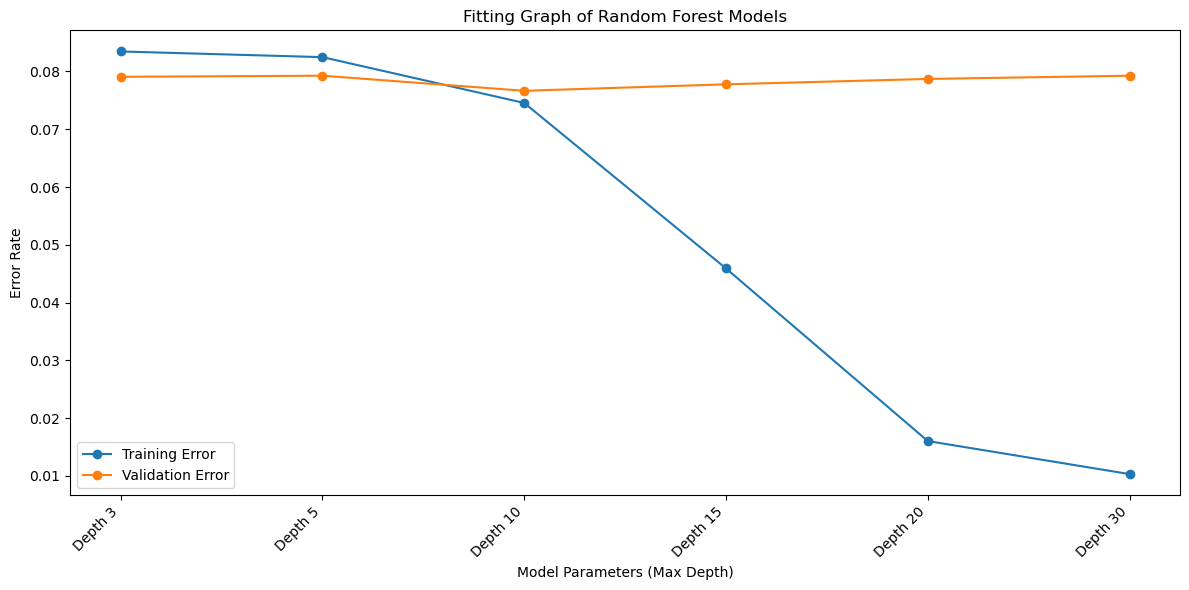

In [56]:
# Gets results for plot
parameters = [r['parameters'] for r in results]
train_errors = [r['train_error'] for r in results]
val_errors = [r['val_error'] for r in results]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(parameters, train_errors, label='Training Error', marker='o')
plt.plot(parameters, val_errors, label='Validation Error', marker='o')
plt.xlabel('Model Parameters (Max Depth)')
plt.ylabel('Error Rate')
plt.title('Fitting Graph of Random Forest Models')
plt.xticks(rotation=45, ha = 'right')
plt.legend()
plt.tight_layout()
plt.show()

#### Results

In [57]:
# Best performance comes from a tree depth of 10
rf_10 = RandomForestClassifier(featuresCol="features",
                               labelCol="safe?",
                               maxDepth=10,
                               seed = 42)
model_10 = rf_10.fit(train_data)

In [58]:
# Retreives the prediction dfs and errors for each split
# Adds a column specifying the dataset
train_predictions = model_10.transform(train_data).withColumn("dataset", f.lit("Train"))
train_error = 1 - evaluator.evaluate(train_predictions)
val_predictions = model_10.transform(validation_data).withColumn("dataset", f.lit("Validation"))
val_error = 1 - evaluator.evaluate(val_predictions)
test_predictions = model_10.transform(test_data).withColumn("dataset", f.lit("Test"))
test_error = 1 - evaluator.evaluate(test_predictions)

In [59]:
# Prints the error rate for each dataset
print(f"Train Error: {train_error}")
print(f"Validation Error: {val_error}")
print(f"Test Error: {test_error}")

Train Error: 0.0745452310717798
Validation Error: 0.07665050354345393
Test Error: 0.07425837320574158


In [60]:
# Creates a groundtruth dataframe to show the accuracy of the predictions
train_pred_safe = train_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
train_pred_unsafe = train_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
val_pred_safe = val_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
val_pred_unsafe = val_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
test_pred_safe = test_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 1).first()
test_pred_unsafe = test_predictions.select('dataset','features', 'safe?', 'prediction').filter(f.col('safe?') == 0).first()
ground_df = sc.createDataFrame([train_pred_safe, 
                                train_pred_unsafe,
                                val_pred_safe,
                                val_pred_unsafe,
                                test_pred_safe,
                                test_pred_unsafe])

In [61]:
# Ground truth df
ground_df.withColumn("correct", f.when(f.col('safe?') == f.col('prediction'), True).otherwise(False)).show()

+----------+--------------------+-----+----------+-------+
|   dataset|            features|safe?|prediction|correct|
+----------+--------------------+-----+----------+-------+
|     Train|[177.0,1.42,26.45...|    1|       1.0|   true|
|     Train|(28,[0,1,2,3,4,5,...|    0|       1.0|  false|
|Validation|(28,[0,1,2,3,4,5,...|    1|       1.0|   true|
|Validation|[2477.0,2.0,28.55...|    0|       1.0|  false|
|      Test|[22.0,-3.0,24.86,...|    1|       1.0|   true|
|      Test|[91.0,-2.0,28.63,...|    0|       1.0|  false|
+----------+--------------------+-----+----------+-------+



#### Confusion Matrix

In [62]:
# Creates RDD from test predictions for making a confusion matrix
predictionAndLabels = test_predictions.select(f.col("prediction"), f.col("safe?"))
predictionAndLabelsRDD = predictionAndLabels.rdd.map(lambda x: (float(x[0]), float(x[1])))

In [63]:
# Produces a confusion matrix pandas dataframe
metrics = MulticlassMetrics(predictionAndLabelsRDD)
confusionMatrix = metrics.confusionMatrix().toArray()
confusion_df = pd.DataFrame(confusionMatrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

/usr/local/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


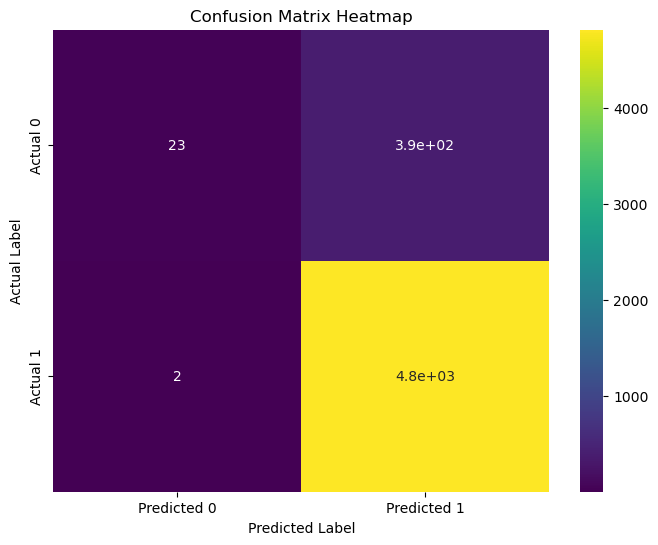

In [64]:
# Shows off confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap="viridis")
plt.title("Confusion Matrix Heatmap")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### Feature Importance

In [65]:
# Returns the most important features for our random forest model
importances = model_10.featureImportances
importance_list = importances.toArray()
for i, importance in enumerate(importance_list):
    print(f"Feature {features[i]}: {importance}")

Feature avg_shoredistance: 0.06566028522507343
Feature avg_bathymetry: 0.05780084558309066
Feature avg_sst: 0.05747530102604237
Feature avg_sss: 0.05358441121150107
Feature sum_count: 0.03303700965930156
Feature log_sum_count: 0.021920699469889157
Feature marine: 0.0017282840766780039
Feature brackish: 0.005392790168265655
Feature freshwater: 0.00306224214511825
Feature terrestrial: 0.013197270023317786
Feature moving_avg_sst: 0.0587821793771988
Feature rolling_stddev_sst: 0.03358819884393728
Feature yoy_change_avg_sst: 0.031552136981814374
Feature moving_avg_sss: 0.05759275357054557
Feature rolling_stddev_sss: 0.04178669058029712
Feature yoy_change_avg_sss: 0.03223858056822417
Feature moving_avg_sum_cnt: 0.034279411293011784
Feature rolling_stddev_sum_cnt: 0.040503016867967645
Feature yoy_change_sum_cnt: 0.022918389150747082
Feature moving_avg_log_cnt: 0.039682327384492795
Feature rolling_stddev_log_cnt: 0.037521771794874106
Feature yoy_change_log_cnt: 0.027173915783774604
Feature dif

In [66]:
# Converts feature importance pairs into a list
feature_importance_pairs = list(zip(features, importance_list))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
sorted_features, sorted_importance_list = zip(*feature_importance_pairs)

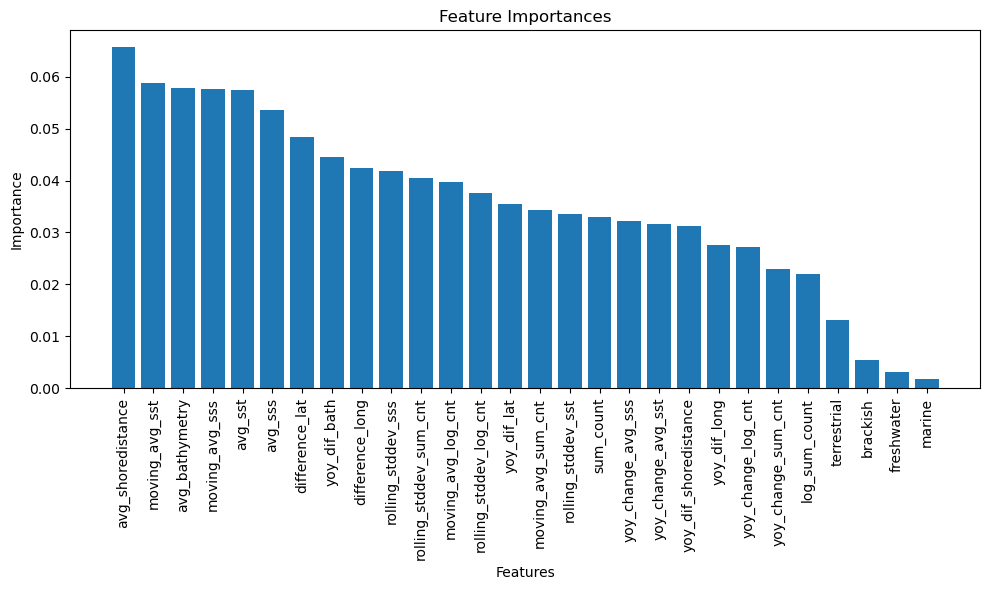

In [67]:
# Plots the feature importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importance_list)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()